In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoCV

In [60]:
df = pd.read_csv('data/cleaned_grit_data.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2200, 101)


,index,country,surveyelapse,GS1,GS2,GS3,GS4,GS5,GS6,GS7,...,browser,introelapse,testelapse,Extraversion,Neuroticism,Agreeableness,Conscientiousness,Openness,Grit,highgrit
0,4,JP,340,5,2,3,3,2,4,2,...,Firefox,3,337,1.2,2.5,3.3,3.8,3.0,3.083333,0
1,6,US,126,4,1,3,2,1,5,1,...,Chrome,36,212,4.0,2.0,3.6,3.4,5.0,2.583333,0
2,8,EU,130,5,3,3,5,4,5,5,...,Microsoft Internet Explorer,14,183,4.4,4.5,4.7,4.0,4.3,4.250000,1
3,10,AE,592,5,3,3,2,4,3,3,...,Chrome,726,311,3.0,4.6,3.6,3.8,3.4,3.166667,0
4,11,AU,217,3,1,1,2,1,3,1,...,Firefox,376,407,2.0,1.1,3.4,3.9,4.4,2.000000,0


#### Binning the Age Column

- Created three age categories:
  - 18-30
  - 30-45
  - 45+
- Stored these in a new column called age_group.
- The original age column has been left untouched for potential future use.

In [61]:
bins = [0, 30, 45, float('inf')] 
labels = ['18-30', '30-45', '45+']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df[['age', 'age_group']].head()

,age,age_group
0,38,30-45
1,35,30-45
2,50,45+
3,52,45+
4,20,18-30


#### Survey Time and Vocabulary Scores

- **Survey Time Score**:  
  - Combined time spent on different sections of the survey to create a composite column called survey_time_score
  - Included columns:
    - introelapse
    - testelapse
    - surveyelapse  

- **Vocabulary Score**:  
  - Created a vacabulary score based on the check-list of words (VCL1–VCL15) and stored it in a cloumn called "vocab_score"
  - Allcolumns wew included except for the previously removed validation columns (VCL6, VCL9, and VCL12)
  - Each checked real word contributes 1 point.  

In [62]:
df['survey_time_score'] = df['introelapse'] + df['testelapse'] + df['surveyelapse']

vcl_cols = ['VCL1','VCL2','VCL3','VCL4','VCL5',
            'VCL7','VCL8','VCL10','VCL11','VCL13','VCL14','VCL15']

df['vocab_score'] = df[vcl_cols].sum(axis=1)


#### Removing Biased Columns

In [63]:
df = df.drop(columns=['education','urban', 'gender', 'engnat', 'hand','religion', 'orientation', 'race','voted','country'])

#### Removing Grit Question and Composite Scores

In [64]:
df = df.drop(columns=['GS1','GS2', 'GS3', 'GS4', 'GS5','GS6', 'GS7', 'GS8','GS9','GS10','GS11','GS12','Extraversion','Neuroticism','Agreeableness','Conscientiousness','Openness'])

#### Encoding Categorical Variables

- Replaced nulls in the education column with the mode, to ensure ordinal encoding works correctly without "Unknown" values.
- Mapped education categories to numbers:
  - "Less than high school" → 0
  - "High school" → 1
  - "University" → 2
  - "Graduate" → 3
- Replaced all other null values with "Unknown".
- One-hot encoded all other categorical columns, excluding country.
- The country column has been left untouched for potential future use.

In [65]:
null_columns = df.isna().sum()
print(null_columns[null_columns > 0])

married    8
dtype: int64


In [66]:
cols_to_fill = ['married']

df['married'] = df['married'].fillna("Unknown")

cols_to_encode = ['married', "browser", "operatingsystem", "age_group"]
print(cols_to_encode)
df = pd.get_dummies(df, columns=cols_to_encode, dummy_na=False)
dummy_cols = [col for col in df.columns if any(orig in col for orig in cols_to_encode)]
df[dummy_cols] = df[dummy_cols].astype(int)

print(df.shape)
df.head()

['married', 'browser', 'operatingsystem', 'age_group']
(2200, 98)


,index,surveyelapse,VCL1,VCL2,VCL3,VCL4,VCL5,VCL7,VCL8,VCL10,...,operatingsystem_ChromeOS,operatingsystem_Linux,operatingsystem_Macintosh,operatingsystem_Unknown,operatingsystem_Windows,operatingsystem_Windows Phone,operatingsystem_iOS,age_group_18-30,age_group_30-45,age_group_45+
0,4,340,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,6,126,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
2,8,130,1,1,1,1,1,0,1,1,...,0,0,0,0,1,0,0,0,0,1
3,10,592,1,0,0,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,11,217,1,1,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [67]:
#code for saving the dataframe
df.reset_index(inplace=True)
df = df.drop(columns=['level_0', 'index'])
df.to_csv('./data/engineered_grit_data.csv', index=False)

In [68]:
df.head()

,surveyelapse,VCL1,VCL2,VCL3,VCL4,VCL5,VCL7,VCL8,VCL10,VCL11,...,operatingsystem_ChromeOS,operatingsystem_Linux,operatingsystem_Macintosh,operatingsystem_Unknown,operatingsystem_Windows,operatingsystem_Windows Phone,operatingsystem_iOS,age_group_18-30,age_group_30-45,age_group_45+
0,340,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,126,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
2,130,1,1,1,1,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,1
3,592,1,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,217,1,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


#### Scaling the Data

I'm unsure if we want to scale our data or if we do then when we want to scale or which columns specificalyy we want to scale so I created a new data frame df_scaled with all features scaled.
- I personally believe that all timing data needs to be scaled at the very least (Fida)

In [15]:
num_cols = df.drop(columns='country').columns

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[num_cols])

df_scaled = pd.DataFrame(df_scaled, columns=num_cols, index=df.index)

df_scaled.head()

,index,surveyelapse,GS1,GS2,GS3,GS4,GS5,GS6,GS7,GS8,...,operatingsystem_ChromeOS,operatingsystem_Linux,operatingsystem_Macintosh,operatingsystem_Unknown,operatingsystem_Windows,operatingsystem_Windows Phone,operatingsystem_iOS,age_group_18-30,age_group_30-45,age_group_45+
0,-1.712706,0.694531,1.127373,-0.448839,0.037770,-0.167678,-0.652937,-0.094981,-0.889894,0.763276,...,-0.102786,-0.321419,-0.422328,-0.077099,0.770846,-0.030165,-0.351562,-1.451670,1.994336,-0.370862
1,-1.711067,-0.738854,0.119563,-1.340036,0.037770,-1.027568,-1.440039,0.872415,-1.730498,-1.559280,...,-0.102786,-0.321419,-0.422328,-0.077099,0.770846,-0.030165,-0.351562,-1.451670,1.994336,-0.370862
2,-1.709428,-0.712061,1.127373,0.442358,0.037770,1.552101,0.921267,0.872415,1.631918,0.763276,...,-0.102786,-0.321419,-0.422328,-0.077099,0.770846,-0.030165,-0.351562,-1.451670,-0.501420,2.696419
3,-1.707789,2.382441,1.127373,0.442358,0.037770,-1.027568,0.921267,-1.062376,-0.049290,-0.010909,...,-0.102786,-0.321419,-0.422328,-0.077099,0.770846,-0.030165,-0.351562,-1.451670,-0.501420,2.696419
4,-1.706969,-0.129330,-0.888247,-1.340036,-1.607645,-1.027568,-1.440039,-1.062376,-1.730498,-0.785094,...,-0.102786,-0.321419,-0.422328,-0.077099,0.770846,-0.030165,-0.351562,0.688862,-0.501420,-0.370862


#### Personality Trait Interactions

In [16]:
df_engineered = df.copy()
traits = ['Openness', 'Conscientiousness', 
          'Extraversion', 'Agreeableness', 'Neuroticism']

In [17]:
# Create all pairwise interactions (10 total combinations)
interaction_features = []
for trait1, trait2 in combinations(traits, 2):
  feature_name = f'{trait1}_x_{trait2}'
  df_engineered[feature_name] = df_engineered[trait1] * df_engineered[trait2]
  interaction_features.append(feature_name)
  print(f"Created: {feature_name}")

print(f"\nTotal interaction features created: {len(interaction_features)}")

Created: Openness_x_Conscientiousness
Created: Openness_x_Extraversion
Created: Openness_x_Agreeableness
Created: Openness_x_Neuroticism
Created: Conscientiousness_x_Extraversion
Created: Conscientiousness_x_Agreeableness
Created: Conscientiousness_x_Neuroticism
Created: Extraversion_x_Agreeableness
Created: Extraversion_x_Neuroticism
Created: Agreeableness_x_Neuroticism

Total interaction features created: 10



Interaction Feature Correlations with Grit:
Conscientiousness_x_Agreeableness    0.615659
Conscientiousness_x_Neuroticism      0.599657
Openness_x_Conscientiousness         0.558125
Conscientiousness_x_Extraversion     0.524512
Agreeableness_x_Neuroticism          0.438798
Extraversion_x_Neuroticism           0.373226
Openness_x_Neuroticism               0.360135
Extraversion_x_Agreeableness         0.288706
Openness_x_Agreeableness             0.262775
Openness_x_Extraversion              0.214245
Name: Grit, dtype: float64


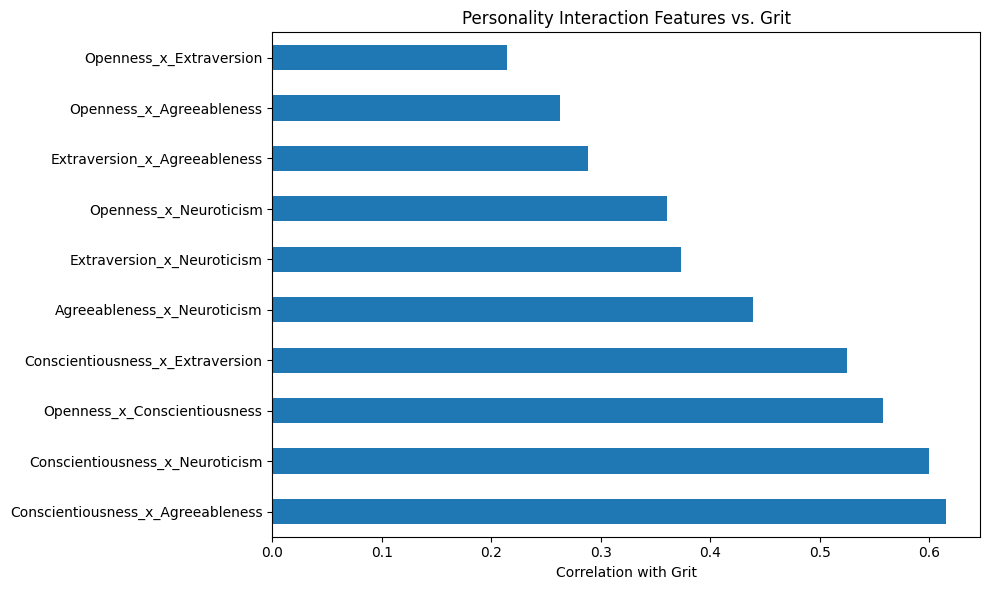

In [18]:
# Check correlations of interaction features with Grit + visualization
interaction_corr = df_engineered[interaction_features + ['Grit']].corr()['Grit'].drop('Grit').sort_values(ascending=False)
print("\nInteraction Feature Correlations with Grit:")
print(interaction_corr)

plt.figure(figsize=(10, 6))
interaction_corr.plot(kind='barh')
plt.xlabel('Correlation with Grit')
plt.title('Personality Interaction Features vs. Grit')
plt.tight_layout()
plt.show()

#### Demographic-Personality Interactions

In [19]:
# INCORRECT, GIVING ERROR
# Age × Conscientiousness
df_engineered['Age_x_Consc'] = df_engineered['age'] * df_engineered['Conscientiousness']

# Age × Openness
df_engineered['Age_x_Open'] = df_engineered['age'] * df_engineered['Openness']

# Education × Openness
df_engineered['Edu_x_Open'] = df_engineered['education'] * df_engineered['Openness']

# Education × Conscientiousness
df_engineered['Edu_x_Consc'] = df_engineered['education'] * df_engineered['Conscientiousness']

demographic_interactions = ['Age_x_Consc', 'Age_x_Open', 'Edu_x_Open', 'Edu_x_Consc']
print("Created demographic interaction features:")
for feat in demographic_interactions:
  print(f"  - {feat}")

Created demographic interaction features:
  - Age_x_Consc
  - Age_x_Open
  - Edu_x_Open
  - Edu_x_Consc


In [20]:
#code for saving the dataframe

#df_engineered.reset_index(inplace=True)
#df_engineered.to_csv('./data/cleaned_grit_data.csv', index=False)

#### Feature Selection

We'll perform feature selection using multiple approaches:
1. EDA-based selection (removing demographic features like religion, race that might introduce bias)
2. Correlation-based selection
3. RFE (Recursive Feature Elimination)
4. LASSO regression for feature importance

#### Examining Target Variable (Grit)
Looking at the distribution of our binary target variable before proceeding with feature selection.

Unique values in Grit column: [3.08333333 2.58333333 4.25       3.16666667 2.         2.08333333
 3.91666667 2.16666667 3.         2.75       3.5        2.91666667
 3.66666667 3.83333333 2.83333333 2.5        2.33333333 2.41666667
 3.25       4.33333333 2.25       4.41666667 2.66666667 4.08333333
 1.83333333 4.5        1.16666667 3.41666667 3.58333333 1.91666667
 3.75       3.33333333 4.         1.5        4.16666667 4.91666667
 1.41666667 4.58333333 4.66666667 1.75       5.         4.83333333
 1.58333333 1.66666667 4.75       1.33333333 1.25       1.08333333]

Value counts in Grit column (class distribution):
Grit
3.083333    104
3.500000    101
3.583333     97
2.916667     93
3.333333     89
3.750000     86
3.666667     86
3.833333     85
3.166667     84
3.916667     84
3.250000     83
3.416667     81
2.666667     80
3.000000     80
4.000000     79
2.500000     76
4.083333     73
2.833333     71
2.583333     68
2.750000     60
4.250000     56
4.166667     55
2.333333     54
2.416667 

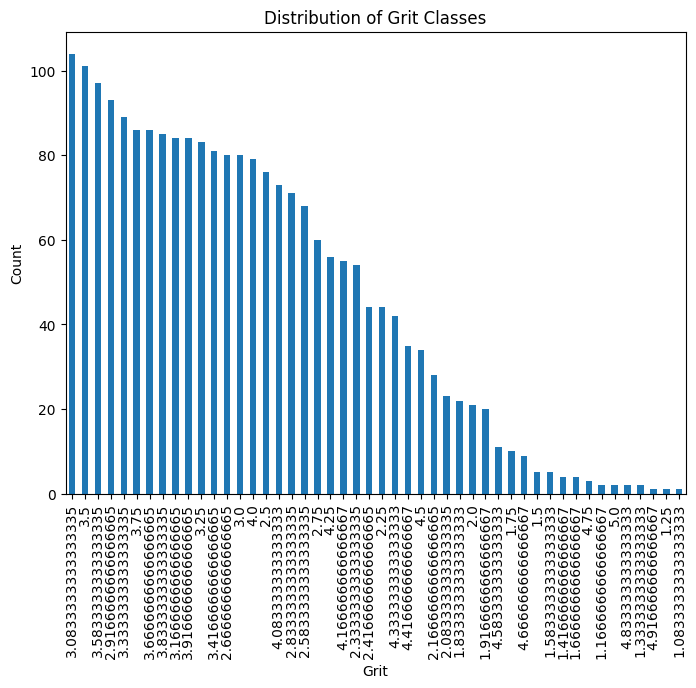

In [35]:
# Examine the distribution of the target variable
print("Unique values in Grit column:", df_engineered['Grit'].unique())
print("\nValue counts in Grit column (class distribution):")
print(df_engineered['Grit'].value_counts())
print("\nClass distribution percentages:")
print(df_engineered['Grit'].value_counts(normalize=True) * 100)

# Visualize the class distribution
plt.figure(figsize=(8, 6))
df_engineered['Grit'].value_counts().plot(kind='bar')
plt.title('Distribution of Grit Classes')
plt.xlabel('Grit')
plt.ylabel('Count')
plt.show()

##### 1. EDA-based Selection
Remove demographic features that might introduce bias or are not relevant for predicting grit.

In [27]:
# Remove demographic features that might introduce bias
demographic_cols = [col for col in df_engineered.columns if any(x in col.lower() for x in ['religion', 'race', 'country', 'married', 'voted'])]
print("Removing demographic columns:", demographic_cols)
X_eda = df_engineered.drop(columns=demographic_cols + ['Grit'])
y = df_engineered['Grit']

print(f"\nFeatures remaining after EDA selection: {X_eda.shape[1]}")

Removing demographic columns: ['country', 'religion_Agnostic', 'religion_Atheist', 'religion_Buddhist', 'religion_Christian (Catholic)', 'religion_Christian (Mormon)', 'religion_Christian (Other)', 'religion_Christian (Protestant)', 'religion_Hindu', 'religion_Jewish', 'religion_Muslim', 'religion_Other', 'religion_Sikh', 'religion_Unknown', 'race_Arab', 'race_Asian', 'race_Black', 'race_Indigenous/Native/White', 'race_Other', 'race_Unknown', 'voted_No', 'voted_Unknown', 'voted_Yes', 'married_Currently married', 'married_Never married', 'married_Previously married', 'married_Unknown']

Features remaining after EDA selection: 146


In [28]:
# Remove demographic features and any columns synonymous with Grit
demographic_cols = [col for col in df_engineered.columns if any(x in col.lower() for x in ['religion', 'race', 'country', 'married', 'voted'])]
grit_related_cols = [col for col in df_engineered.columns if 'grit' in col.lower()]  # Exclude any columns with 'grit' in the name
print("Removing demographic columns:", demographic_cols)
print("Excluding Grit-related columns:", grit_related_cols)

X_eda = df_engineered.drop(columns=demographic_cols + grit_related_cols)
y = df_engineered['Grit']

print(f"\nFeatures remaining after EDA selection: {X_eda.shape[1]}")
print("\nFirst few remaining features:", list(X_eda.columns)[:5])

Removing demographic columns: ['country', 'religion_Agnostic', 'religion_Atheist', 'religion_Buddhist', 'religion_Christian (Catholic)', 'religion_Christian (Mormon)', 'religion_Christian (Other)', 'religion_Christian (Protestant)', 'religion_Hindu', 'religion_Jewish', 'religion_Muslim', 'religion_Other', 'religion_Sikh', 'religion_Unknown', 'race_Arab', 'race_Asian', 'race_Black', 'race_Indigenous/Native/White', 'race_Other', 'race_Unknown', 'voted_No', 'voted_Unknown', 'voted_Yes', 'married_Currently married', 'married_Never married', 'married_Previously married', 'married_Unknown']
Excluding Grit-related columns: ['Grit', 'highgrit']

Features remaining after EDA selection: 145

First few remaining features: ['index', 'surveyelapse', 'GS1', 'GS2', 'GS3']


##### 2. Correlation-based Selection
Select features based on their correlation with the target variable (Grit) and remove highly correlated features to reduce multicollinearity.

In [29]:
# Calculate correlations with target
correlations = X_eda.corrwith(y).sort_values(ascending=False)
print("Top 10 features by correlation with Grit:")
print(correlations.head(10))

# Identify highly correlated feature pairs
corr_matrix = X_eda.corr()
high_corr_features = np.where(np.abs(corr_matrix) > 0.8)
high_corr_features = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                      for x, y in zip(*high_corr_features) if x != y and x < y]

print("\nHighly correlated feature pairs (correlation > 0.8):")
for feat1, feat2, corr in high_corr_features:
    print(f"{feat1} - {feat2}: {corr:.3f}")

# Select features based on correlation threshold with target
correlation_threshold = 0.1
selected_features = correlations[abs(correlations) > correlation_threshold].index.tolist()
X_corr = X_eda[selected_features]

print(f"\nFeatures selected after correlation-based selection: {len(selected_features)}")
print("Selected features:", selected_features)

Top 10 features by correlation with Grit:
GS8                                  0.756146
GS7                                  0.724044
GS5                                  0.701019
GS9                                  0.697088
Conscientiousness                    0.643038
GS10                                 0.642539
Conscientiousness_x_Agreeableness    0.615659
Conscientiousness_x_Neuroticism      0.599657
GS12                                 0.595183
GS2                                  0.590353
dtype: float64

Highly correlated feature pairs (correlation > 0.8):
education - Edu_x_Open: 0.942
education - Edu_x_Consc: 0.907
age - age_group_18-30: -0.856
age - Age_x_Consc: 0.898
age - Age_x_Open: 0.920
testelapse - survey_time_score: 0.856
Extraversion - Openness_x_Extraversion: 0.903
Extraversion - Conscientiousness_x_Extraversion: 0.812
Extraversion - Extraversion_x_Agreeableness: 0.897
Neuroticism - Openness_x_Neuroticism: 0.888
Neuroticism - Conscientiousness_x_Neuroticism: 0.852
Ne

##### 3. Recursive Feature Elimination (RFE)
Use RFE with LinearRegression to select features based on their importance.

In [30]:
# Perform RFE
n_features_to_select = 20  # You can adjust this number
lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=n_features_to_select)
rfe.fit(X_corr, y)

# Get selected features and their ranking
rfe_feature_ranks = pd.Series(rfe.ranking_, index=X_corr.columns)
selected_features_rfe = X_corr.columns[rfe.support_].tolist()

print("Features selected by RFE:", len(selected_features_rfe))
print("\nFeature Rankings (1 indicates selected, higher numbers indicate order of elimination):")
print(rfe_feature_ranks.sort_values())

Features selected by RFE: 20

Feature Rankings (1 indicates selected, higher numbers indicate order of elimination):
GS8                              1
GS1                              1
GS11                             1
GS4                              1
C6                               1
                                ..
E6                              52
E3                              53
Age_x_Consc                     54
Age_x_Open                      55
Extraversion_x_Agreeableness    56
Length: 75, dtype: int64


##### 4. LASSO Feature Selection
Use LASSO regression for feature selection. LASSO will automatically set coefficients of less important features to zero.

In [31]:
# Perform LASSO feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_corr, y)

# Get feature importance from LASSO
lasso_feature_importance = pd.Series(abs(lasso.coef_), index=X_corr.columns)
selected_features_lasso = lasso_feature_importance[lasso_feature_importance > 0].index.tolist()

print("Features selected by LASSO:", len(selected_features_lasso))
print("\nLASSO Feature Importance:")
print(lasso_feature_importance.sort_values(ascending=False))

Features selected by LASSO: 18

LASSO Feature Importance:
GS8                         0.083691
GS10                        0.082955
GS7                         0.082161
GS5                         0.081414
GS9                         0.079844
                              ...   
E3                          0.000000
C7                          0.000000
Openness_x_Agreeableness    0.000000
N6                          0.000000
age_group_18-30             0.000000
Length: 75, dtype: float64


##### Feature Selection Comparison and Ranking
Compare features selected by different methods and create an overall ranking based on their importance across methods.

In [32]:
# Create a DataFrame to compare feature selection methods
feature_comparison = pd.DataFrame(index=X_corr.columns)

# Add correlation values
feature_comparison['Correlation'] = abs(correlations[X_corr.columns])

# Add RFE rankings (convert to 0-1 scale where 1 is best)
feature_comparison['RFE_Rank'] = 1 / rfe_feature_ranks
feature_comparison['RFE_Selected'] = rfe.support_

# Add LASSO importance
feature_comparison['LASSO_Importance'] = abs(lasso.coef_)

# Calculate composite score (normalized sum of all metrics)
for col in ['Correlation', 'RFE_Rank', 'LASSO_Importance']:
    feature_comparison[f'{col}_Normalized'] = feature_comparison[col] / feature_comparison[col].max()

feature_comparison['Composite_Score'] = (
    feature_comparison['Correlation_Normalized'] + 
    feature_comparison['RFE_Rank_Normalized'] + 
    feature_comparison['LASSO_Importance_Normalized']
) / 3

# Sort by composite score
final_ranking = feature_comparison.sort_values('Composite_Score', ascending=False)

print("Final Feature Rankings (based on composite score):")
print(final_ranking[['Correlation', 'RFE_Rank', 'LASSO_Importance', 'Composite_Score']])

# Create a summary of selected features across methods
feature_summary = pd.DataFrame({
    'Selected_by_Correlation': [x in selected_features for x in X_corr.columns],
    'Selected_by_RFE': rfe.support_,
    'Selected_by_LASSO': [x in selected_features_lasso for x in X_corr.columns]
})

# Count how many methods selected each feature
feature_summary['Times_Selected'] = feature_summary.sum(axis=1)
print("\nFeatures selected by multiple methods:")
print(feature_summary[feature_summary['Times_Selected'] > 1].sort_values('Times_Selected', ascending=False))

Final Feature Rankings (based on composite score):
                                     Correlation  RFE_Rank  LASSO_Importance  \
GS8                                     0.756146  1.000000          0.083691   
GS7                                     0.724044  1.000000          0.082161   
GS5                                     0.701019  1.000000          0.081414   
GS9                                     0.697088  1.000000          0.079844   
GS10                                    0.642539  1.000000          0.082955   
...                                          ...       ...               ...   
age_group_30-45                         0.129564  0.032258          0.000000   
A9                                      0.123809  0.035714          0.000000   
browser_Microsoft Internet Explorer     0.120841  0.037037          0.000000   
E1                                      0.110668  0.023810          0.000000   
E2                                      0.107363  0.022222          0

### Feature Selection Results and Recommendations

#### Why use multiple features?
For predicting Grit, using multiple features is recommended over a single feature because:
- Grit is a complex psychological construct influenced by multiple factors
- Multiple features can capture different aspects of personality and behavior
- Using multiple validated features reduces the risk of overfitting

#### Recommended Feature Sets:

1. **Core Feature Set** (Features selected by all three methods):
   - Features that were consistently selected by Correlation, RFE, and LASSO
   - These are the most robust predictors

2. **Extended Feature Set** (Features selected by at least two methods):
   - Includes features that showed strong predictive power in multiple approaches
   - Provides a broader range of predictors while maintaining reliability

3. **Comprehensive Feature Set** (Top features by composite score):
   - Includes all features with high composite scores
   - Best for complex modeling where computational resources aren't a constraint

#### For Different Modeling Approaches:

1. **Linear Regression**:
   - Start with the Core Feature Set
   - Add features from Extended Set if they improve model performance
   - Watch for multicollinearity between features

2. **Multiple Regression**:
   - Use the Extended Feature Set
   - Consider interaction terms between key features
   - Monitor VIF (Variance Inflation Factor) for multicollinearity

3. **Classification Models**:
   - Can use the Comprehensive Feature Set
   - Feature importance can be re-evaluated using model-specific metrics
   - Consider feature scaling for certain algorithms

#### Final Recommendation:
Start with the Extended Feature Set (features selected by at least two methods) as it provides:
- Good balance between model complexity and performance
- Robust feature selection validated by multiple methods
- Sufficient information while avoiding redundancy

Monitor model performance and adjust feature set based on:
- Cross-validation results
- Model complexity requirements
- Computational constraints
- Specific domain knowledge requirements

In [ ]:
# Display the specific features in each recommended set

# Core features (selected by all three methods)
core_features = feature_summary[feature_summary['Times_Selected'] == 3].index.tolist()
print("Core Features (selected by all methods):")
print(core_features)
print("\nNumber of core features:", len(core_features))

# Extended features (selected by at least two methods)
extended_features = feature_summary[feature_summary['Times_Selected'] >= 2].index.tolist()
print("\nExtended Features (selected by at least two methods):")
print(extended_features)
print("\nNumber of extended features:", len(extended_features))

# Top features by composite score (top 20)
top_composite_features = final_ranking.head(20).index.tolist()
print("\nTop 20 Features by Composite Score:")
print(top_composite_features)


Feature with highest correlation to Grit: GS8

First 5 rows of GS8:
0    4
1    1
2    4
3    3
4    2
Name: GS8, dtype: int64


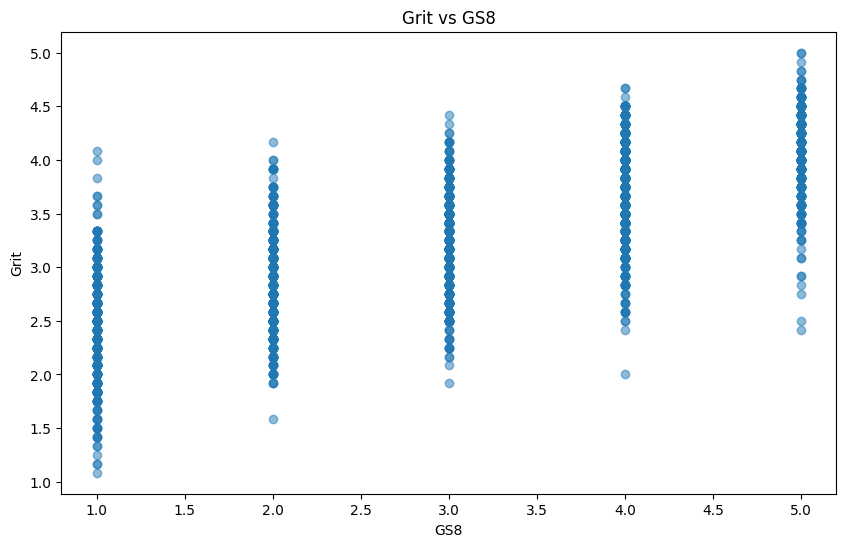

In [ ]:
# Get the name of the feature with highest correlation
top_corr_feature = correlations.index[0]
print(f"\nFeature with highest correlation to Grit: {top_corr_feature}")
print(f"\nFirst 5 rows of {top_corr_feature}:")
print(df_engineered[top_corr_feature].head())

# Show a scatter plot of this feature vs Grit
plt.figure(figsize=(10, 6))
plt.scatter(df_engineered[top_corr_feature], df_engineered['Grit'], alpha=0.5)
plt.xlabel(top_corr_feature)
plt.ylabel('Grit')
plt.title(f'Grit vs {top_corr_feature}')
plt.show()

In [34]:
# Let's examine the distribution of the Grit column to confirm it's binary
print("Unique values in Grit column:", df_engineered['Grit'].unique())
print("\nValue counts in Grit column:")
print(df_engineered['Grit'].value_counts())

# Remove any features that are too highly correlated with Grit (might be binary encodings of the same information)
very_high_corr_threshold = 0.9  # Adjust this threshold as needed
high_corr_with_grit = correlations[abs(correlations) > very_high_corr_threshold].index.tolist()
print("\nFeatures extremely correlated with Grit (potentially redundant):")
print(high_corr_with_grit)

# Remove these features and recalculate correlations
X_filtered = X_eda.drop(columns=high_corr_with_grit)
correlations_filtered = X_filtered.corrwith(y).sort_values(ascending=False)

print("\nTop 10 features by correlation with Grit (after removing redundant features):")
print(correlations_filtered.head(10))

# Update feature selection with filtered features
correlation_threshold = 0.1
selected_features_filtered = correlations_filtered[abs(correlations_filtered) > correlation_threshold].index.tolist()
X_corr_filtered = X_filtered[selected_features_filtered]

print(f"\nFeatures selected after correlation-based selection (excluding binary duplicates): {len(selected_features_filtered)}")
print("Selected features:", selected_features_filtered)

Unique values in Grit column: [3.08333333 2.58333333 4.25       3.16666667 2.         2.08333333
 3.91666667 2.16666667 3.         2.75       3.5        2.91666667
 3.66666667 3.83333333 2.83333333 2.5        2.33333333 2.41666667
 3.25       4.33333333 2.25       4.41666667 2.66666667 4.08333333
 1.83333333 4.5        1.16666667 3.41666667 3.58333333 1.91666667
 3.75       3.33333333 4.         1.5        4.16666667 4.91666667
 1.41666667 4.58333333 4.66666667 1.75       5.         4.83333333
 1.58333333 1.66666667 4.75       1.33333333 1.25       1.08333333]

Value counts in Grit column:
Grit
3.083333    104
3.500000    101
3.583333     97
2.916667     93
3.333333     89
3.750000     86
3.666667     86
3.833333     85
3.166667     84
3.916667     84
3.250000     83
3.416667     81
2.666667     80
3.000000     80
4.000000     79
2.500000     76
4.083333     73
2.833333     71
2.583333     68
2.750000     60
4.250000     56
4.166667     55
2.333333     54
2.416667     44
2.250000     4